### Part A

##### 1. Load the CSV with date parsing and set `date` as a datetime index.
##### 2. Inspect structure with `info()`, `describe()`, and missing-value counts.
##### 3. Coerce invalid `pm25` strings to `NaN`.
##### 4. Choose and apply a missing-value strategy for `pm25` and justify it.

In [2]:
import pandas as pd
import numpy as np

#1 
df = pd.read_csv(r"C:\Users\Hp Envy\Downloads\m1-09-assessment.csv", parse_dates=["date"])
df = df.set_index("date")

df_= df.copy() # I did it just for myself

#2
df.info()
df.describe()
df.isna().sum()
    
#3
df["pm25"] = pd.to_numeric(df["pm25"], errors="coerce")

#4
df["pm25"] = df["pm25"].interpolate(method="time")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900 entries, 2023-01-01 to 2023-06-29
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          900 non-null    object 
 1   avg_temp_c    863 non-null    float64
 2   humidity_pct  900 non-null    float64
 3   pm25          850 non-null    float64
dtypes: float64(3), object(1)
memory usage: 35.2+ KB


##### I chose interpolate strategy , because PM2.5 is a time-varying indicator. 
##### Simply filling in missing values ​​with the mean may not be accurate. 
##### Time-based interpolation preserves the continuity of the signal and  gives more realistic results

### Part B

##### 5. Identify the city with the highest percentage of invalid/missing `pm25`.
##### 6. Compute a 7-day rolling average of `pm25` per city and explain why this helps interpretation.
##### 7. Define a percentile-based high-pollution threshold and count events per city.
##### 8. Compare volatility between two cities using a metric you define and justify.
##### 9. Create a month-by-city pivot table of average `pm25`.

In [3]:
#5
city = df_.groupby("city")["pm25"].apply(lambda x: x.isna().mean() * 100)
print(city.idxmax(), city.max())

#6
rolling_avg_7day = df_.groupby("city")["pm25"].transform(lambda x: x.rolling(window=7).mean())


Berlin 7.777777777777778


#### A 7-day rolling average smooths short-term fluctuations and reduces noise. It highlights medium-term trends and removes daily volatility effects such as weather shocks.

In [4]:
#7
high_pollution_threshold = np.percentile(df["pm25"], 90)
high_pollution_per_city = (
    df[df["pm25"] > high_pollution_threshold]
      .groupby("city")["pm25"]
      .count())
high_pollution_per_city

#8
volatility_per_city = df.groupby("city")["pm25"].std()
volatility_per_city.sort_values(ascending=False)

city
Warsaw    12.828163
London    12.305268
Paris     11.633935
Berlin    11.611089
Madrid    11.559398
Name: pm25, dtype: float64

##### The mean PM2.5 values for each city are almost similar. 
##### Therefore, I chose standard deviation as the metric, because it indicates in which city PM2.5 fluctuates the most. 
##### Comparing Warsaw and Madrid, the standard deviation shows that Warsaw is more volatile than Madrid

In [5]:
#9
month_by_city_avg_pm25= pd.pivot_table(
    df,
    values="pm25",
    index="city",
    columns=df.index.month_name(),
    aggfunc="mean"
)
month_by_city_avg_pm25

date,April,February,January,June,March,May
city,,,,,,
Berlin,21.855667,33.117500,33.193226,9.872759,29.531613,15.200645
London,24.864333,33.274286,33.275806,9.099310,29.737742,13.987742
Madrid,22.269000,34.651786,33.006452,10.201724,30.315484,15.118387
Paris,23.049333,34.326786,35.021935,9.280345,26.736774,14.055161
Warsaw,20.749333,34.818571,37.239032,9.288966,27.736129,14.262903


### Part C

##### 10. Compute average `pm25` by city.
##### 11. Compute monthly average `pm25` per city.
##### 12. Identify the hottest day (`max avg_temp_c`) per city

In [6]:
#10
avg_pm25_per_city = df.groupby("city")["pm25"].mean()

#11
df["month"] = df.index.month

monthly_avg_pm25_per_city = (
    df.groupby(["city", "month"])["pm25"]
      .mean()
      .unstack()
      .sort_index(axis=1)
)

#12
idx = df.groupby("city")["avg_temp_c"].idxmax()
hottest_day_per_city = df.loc[idx, ["city", "avg_temp_c"]]

### Part D

##### 13. Line plot of monthly `pm25` trends for at least two cities.
##### 14. Bar chart of overall average `pm25` by city.
##### 15. One additional plot of your choice.

Text(0, 0.5, 'max average temperature')

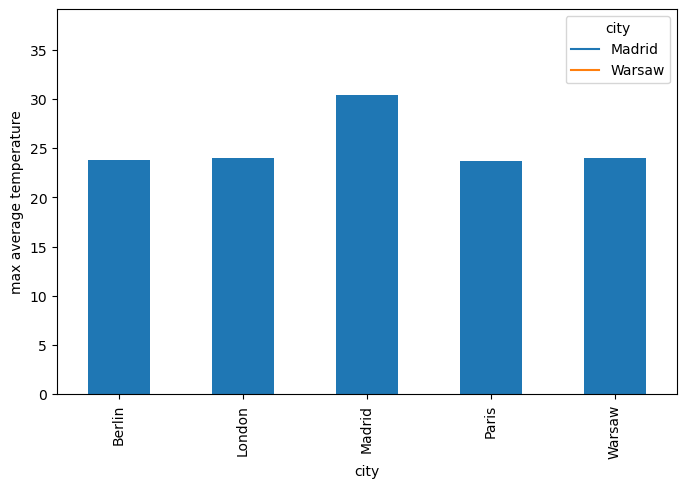

In [7]:
#13
df_selected = df[df["city"].isin(["Warsaw", "Madrid"])].copy()

df_selected["month"] = df_selected.index.to_period("M")

monthly = (
    df_selected
    .groupby(["city", "month"])["pm25"]
    .mean()
    .unstack(0)
)
monthly.plot(figsize=(8,5))

#14
bar_plot = df.groupby("city")["pm25"].mean().plot(kind = "bar")
bar_plot.set_ylabel("mean of pm25")

#15
bar_plot_2 = df.groupby("city")["avg_temp_c"].max().plot(kind="bar")
bar_plot_2.set_ylabel("max average temperature")

### Part E

### 1. Which city has the most persistent high `pm25`, and why?

#### Berlin, because humidity is more and temoerature is lower

### 2. How does missing/invalid data affect confidence in results?

#### Because sometimes missing or invalid data can be unexpected. For example, they may be outliers, may not reflect the true mean, or may distort trends. If we don't handle them correctly, the results can be wrong or biased.

### 3. Does temperature appear related to `pm25` in your analysis?

#### Apprexiamtely yeah. Because there is an inverse realtionship between temperature and pm25. When temperature is high, pm25 is low. But when temperature is low, pm25 is high

### 4. What is one limitation of daily averages for policy decisions?

#### One limitation of daily averages is that they can hide short-term spikes or extreme events. For example, a city might have a very high PM2.5 level for a few hours, but the daily average smooths it out, making it seem less severe. This can mislead policy decisions if actions are based only on daily averages. For example, it mey lead to underestimating risks for public health and misinforming policy decisions.

### 5. What additional dataset would improve this analysis, and why?

#### Dataset about high industrial activity and traffic jams of cities would improve this analysis. Beacuse theses facors affect pm25 levels of cities. So this datasset would help us explain variations in air pollution